# Point Counting Procedure: Minimizing bias and tracking counts w/ reCaptcha style framework

## Importing packages

In [24]:
import math
import pandas as pd
import numpy as np
import statistics as stats
from colorama import Fore
import matplotlib.pyplot as plt
import xlsxwriter
from PIL import Image, ImageOps
import pygame
import numpy as np
import random

pygame 2.5.2 (SDL 2.28.3, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Determine the home directory for the project

In [106]:
import os
from pathlib import Path
home = str(Path(os.getcwd()).parent.parent)
external_drive_path = '/Volumes/T7'

## Taking in an Image
If errors ensue after running this just run it again. os.listdir() includes the .DS_store file so this will sometimes get chosen instead of an image

In [107]:
def grab_random_image(folder_path):
    # List all files in the specified directory
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Check if the directory is empty
    if not files:
        return None
    
    # Choose a random file from the list
    random_file = random.choice(files)
    
    hidden_meta = random_file[0:7]
    image_path = os.path.join(folder_path, random_file)
    return image_path, hidden_meta

# This will be depricated soon, this approach is just easier for test cases
images_directory = home + '/Sample_Images'
random_image = grab_random_image(images_directory)[0]
image_name = random_image[-11:]
chosen_image = random_image
print(image_name)

Img0008.tif


## Setup Subdirectories

In [108]:
def create_subdirectories(path):
    if path == home:
        print(Fore.RED + "Warning: Image segmentation will generate >1000 images. It is recomended that path != the home directory.")

    training_data_directory = path + '/Training_data'

    # Create the subdir for the image
    image_subdir = training_data_directory + '/All_data'
    if not os.path.exists(image_subdir):
        os.makedirs(image_subdir)
        
        # Create the constituent subdirs for the image
        dirs = [image_subdir + '/Ooids', image_subdir + '/Micrite', image_subdir + '/Cement', image_subdir + '/Organics', image_subdir + '/None', image_subdir + '/Unknown', image_subdir + '/Unlabeled']
        for directory in dirs: 
            if not os.path.exists(directory): 
                os.makedirs(directory) 


create_subdirectories(external_drive_path)

## Crop the image and save the segments as unlabeled
    We'll code our own 2-d quad-tree space partitioning algorithm to section the image into segments of various resolution and zoom and grouping. This is nice because areas not part of the actual sample in the image will be allocated large areas and thus can be skipped over more efficiently. This is very over the top, yes, but Kevin Wayne would be proud. Hue bassed procedure adopted from Ho et. al. 2017 "A Hue-Based Quad-Tree Method for Color Image Segmentation" and codebase taken from https://jrtechs.net/photography/segmenting-images-with-quadtrees. 

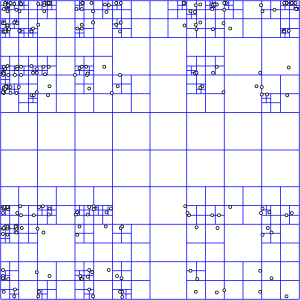
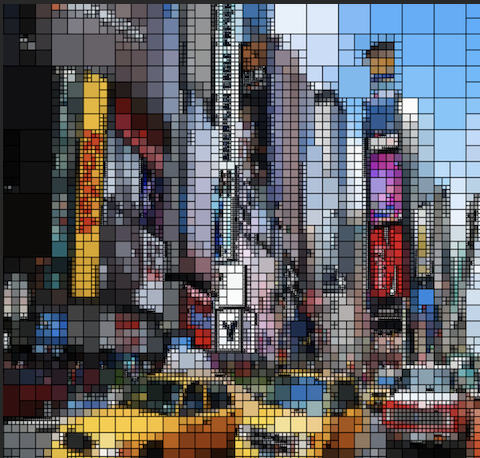


In [109]:
# Open cv library
import cv2

# matplotlib for displaying the images 
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Useful for displaying outputs
def printI(img):
    fig= plt.figure(figsize=(20, 20))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    
    
def printI2(i1, i2):
    fig= plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(cv2.cvtColor(i1, cv2.COLOR_BGR2RGB))
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))

In [110]:
# Beginning of quad-tree implementation
class Node():
    # JRtechs uses implicit pointers by representing the quad-tree as an array. Computationally this is slow and lookup can be 
    # improved to Ω(log4(n)) with a linked implementation however, im unsure how the python backend favors these two cases. both are probably Θ(log4(n)) avg case
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []
    
    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self):
        return self.points
    
    def get_points(self, img):
        return img[self.x0:self.x0 + self.get_width(), self.y0:self.y0+self.get_height()]
    
    # Energy method used for determining partitions based on color similarity
    def get_error(self, img):
        pixels = self.get_points(img)
        b_avg = np.mean(pixels[:,:,0])
        b_mse = np.square(np.subtract(pixels[:,:,0], b_avg)).mean()
    
        g_avg = np.mean(pixels[:,:,1])
        g_mse = np.square(np.subtract(pixels[:,:,1], g_avg)).mean()
        
        r_avg = np.mean(pixels[:,:,2])
        r_mse = np.square(np.subtract(pixels[:,:,2], r_avg)).mean()
        
        e = r_mse * 0.2989 + g_mse * 0.5870 + b_mse * 0.1140
        
        return (e * img.shape[0]* img.shape[1])/90000000

In [111]:
# Quadtree implementation
class QTree():
    def __init__(self, stdThreshold, minPixelSize, img):
        self.threshold = stdThreshold                             # Determines the tolerance for color differences
        self.min_size = minPixelSize                              # Minimum segment size
        self.minPixelSize = minPixelSize
        self.img = img                                            # Image instance
        self.root = Node(0, 0, img.shape[0], img.shape[1])        # Root of the qtree
        self.rgb_copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Image copy in rgb for splicing

    def get_points(self):
        return img[self.root.x0:self.root.x0 + self.root.get_width(), self.root.y0:self.root.y0+self.root.get_height()]
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold, self.minPixelSize, self.img)
    
    # Display the qtree
    def graph_tree(self):
        fig = plt.figure(figsize=(10, 10))
        plt.title("Quadtree")
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        for n in c:
            plt.gcf().gca().add_patch(patches.Rectangle((n.y0, n.x0), n.height, n.width, fill=False))
        plt.gcf().gca().set_xlim(0,img.shape[1])
        plt.gcf().gca().set_ylim(img.shape[0], 0)
        plt.axis('equal')
        plt.show()
        return
    
    # Returns the rbg values for the indices of each segment, an array of 2d arrays
    def readable_children(self):
        c = find_children(self.root)
        segments = []
        
        # iterate through each node and get the image segment
        for n in c:
            segment = extract_subarray(self.rgb_copy, n.y0, n.x0, n.height, n.width)              
            segments.append(segment)
            
        return segments
    
    # Used for meta and tracking %Mapped
    def num_children(self):
        return len(find_children(self.root))

    # Left this in from JRtechs but we dont need it. Returns the color grouped image whereby each segment
    # is the mean color of each pixel in the segment. Fun to play around with though
    def render_img(self, thickness = 1, color = (0,0,255)):
        imgc = self.img.copy()
        c = find_children(self.root)
        for n in c:
            pixels = n.get_points(self.img)
            # grb
            gAvg = math.floor(np.mean(pixels[:,:,0]))
            rAvg = math.floor(np.mean(pixels[:,:,1]))
            bAvg = math.floor(np.mean(pixels[:,:,2]))

            # imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 0] = gAvg
            # imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 1] = rAvg
            # imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 2] = bAvg

        if thickness > 0:
            for n in c:
                # Draw a rectangle
                imgc = cv2.rectangle(imgc, (n.y0, n.x0), (n.y0+n.get_height(), n.x0+n.get_width()), color, thickness)
        return imgc

In [39]:
# Function to perform the quadtree partitioning, created 4 children for parent node
def recursive_subdivide(node, k, minPixelSize, img):

    if node.get_error(img)<=k:
        return
    w_1 = int(math.floor(node.width/2))
    w_2 = int(math.ceil(node.width/2))
    h_1 = int(math.floor(node.height/2))
    h_2 = int(math.ceil(node.height/2))


    if w_1 <= minPixelSize or h_1 <= minPixelSize:
        return
    x1 = Node(node.x0, node.y0, w_1, h_1) # top left
    recursive_subdivide(x1, k, minPixelSize, img)

    x2 = Node(node.x0, node.y0+h_1, w_1, h_2) # btm left
    recursive_subdivide(x2, k, minPixelSize, img)

    x3 = Node(node.x0 + w_1, node.y0, w_2, h_1)# top right
    recursive_subdivide(x3, k, minPixelSize, img)

    x4 = Node(node.x0+w_1, node.y0+h_1, w_2, h_2) # btm right
    recursive_subdivide(x4, k, minPixelSize, img)

    node.children = [x1, x2, x3, x4]
    
# Recurse through the qtree
def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children += (find_children(child))
    return children

# Splice a segment from the image. NGL I think np already has a function for this
def extract_subarray(array, start_row, start_col, height, width):
    # Get the number of rows and columns in the original array
    num_rows = len(array)
    num_cols = len(array[0])

    # Ensure the subarray boundaries are within the original array's boundaries
    end_row = min(start_row + height, num_rows)
    end_col = min(start_col + width, num_cols)

    # Extract the subarray using list comprehension
    subarray = [row[start_col:end_col] for row in array[start_row:end_row]]

    return subarray

In [40]:
qtTemp = QTree(20, 20, img)  #contrast threshold, min cell size, img
qtTemp.subdivide() # recursively generates quad tree
qtTemp.graph_tree()

qtTemp2 = QTree(20, 20, img) 
qtTemp2.subdivide()
qtTemp2.graph_tree()

NameError: name 'img' is not defined

In [41]:
# More for displaying images
def concat_images(img1, img2, boarder=5, color=(255,255,255)):
    img1_boarder = cv2.copyMakeBorder(
                 img1, 
                 boarder, #top
                 boarder, #btn
                 boarder, #left
                 boarder, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    img2_boarder = cv2.copyMakeBorder(
                 img2, 
                 boarder, #top
                 boarder, #btn
                 0, #left
                 boarder, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    return np.concatenate((img1_boarder, img2_boarder), axis=1)

Number of segments: 955


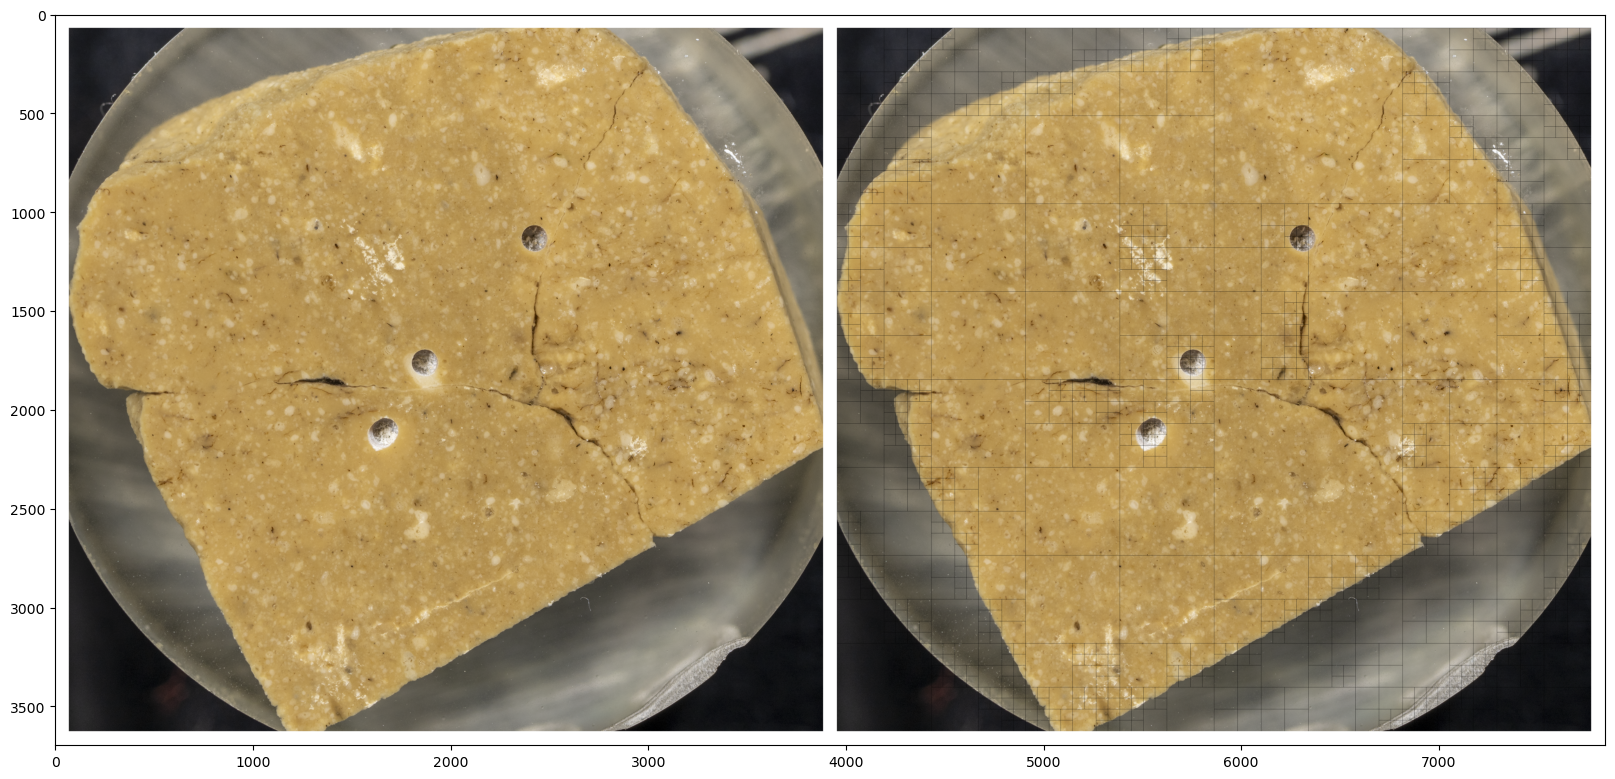

In [96]:
def displayQuadTree(img_name, threshold, minCell, img_boarder, line_boarder, line_color=(0,0,255)):
    imgT= cv2.imread(img_name)
    qt = QTree(threshold, minCell, imgT) 
    qt.subdivide()
    qtImg= qt.render_img(thickness=line_boarder, color=line_color)
    file_name = "output/" + img_name.split("/")[-1]
    # cv2.imwrite(file_name,qtImg)
    file_name_2 = "output/diptych-" + img_name[-6] + img_name[-5] + ".jpg"
    hConcat = concat_images(imgT, qtImg, boarder=img_boarder, color=(255,255,255))
    # cv2.imwrite(file_name_2,hConcat)
    print("Number of segments: %d" %qt.num_children())
    printI(hConcat)

displayQuadTree("/Users/coltenrodriguez/Desktop/ResolutionGuyotProj/Sample_Images/Img0008.tif", threshold=35, minCell=50, img_boarder=70, line_color=(0,0,0), line_boarder = 1)

In [97]:
# Saving the segments of the quadtree to /Unlabeled
def slice_segments(in_image, imName, external_drive_path):
    image = cv2.imread(random_image)
    image_informal_name = imName[0:7]
    
    meta_data_filename = str(external_drive_path + "/Training_data" + "/" + image_informal_name + "_meta.txt")
    unlabeled_segments_path = str(external_drive_path + "/Training_data" + "/" + image_informal_name + "/Unlabeled")
    
    # Keep some image metadata for later
    if not os.path.exists(meta_data_filename):  
        f = open(meta_data_filename, "x")
        f.write(str(image.shape[0] * image.shape[1]))
        f.close()

    # partition (redundant)
    qtIm = QTree(35, 50, image)
    qtIm.subdivide()

    # Traverse the tree
    segments = qtIm.readable_children()

    print(Fore.RED + "WARNING: " + str(len(segments)) + " image segments " + " will be saved to " + external_drive_path + "/Training_data/" + imName[0:7] + "/Unlabeled")
    kill_process = input("Type 'quit' to stop or anything else to continue: ")
    if kill_process == 'quit':
        return
    else:
        for segment, i in zip(segments, range(0, len(segments))):
            #print(np.array(segment).shape)
            # Throws a value error but should be okay to ignore
            # The Value error is, in fact, not okay to ignore and now everything is broken
            im = Image.fromarray(np.array(segment))
            # im.save(unlabeled_segments_path + '/' + str(i) + '.png')
        
slice_segments(random_image, image_name, external_drive_path)

Type 'quit' to stop or anything else to continue:  goi


ValueError: tile cannot extend outside image

## Tracking classifications (Point counting)

    It would be nice if we could generate training data and do point counting simultaneuously. To do this, lets just keep a spreadsheet, with column headers as the various constituents and row headers as the image name (we can arrange them by depth later when we know this info, but for now not knowing this is best as it mitigates bias). Each time we complete a captcha for an image segment the percent of each constituent in this spreadsheet will be updated, essentially maintaining a running tally for point counts. It is also a good idea to make a column called 'percent_mapped' -- the percent area of the image mapped so we know for which images point counting is complete. You can imagine if our random capta segmentation only picks imaged from half a sample we will obtain a bias representation of the constituents. This is obviously not the time-optimal way to point count, but its eliminates A LOT of bias that comes with manual mapping of constituents for each image individually.

### Make and Format a Spreadsheet

In [105]:
# for the row headers 
external_drive_path = '/Volumes/T7'

def grab_all_image_names(folder_path):
    # List all files in the specified directory
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Check if the directory is empty
    if not files:
        return None
    
    # Return all image names
    image_names = []
    for file in files:
        image_names.append(file[0:7])
    
    return image_names


spreadsheet_directory = home
images_directory = spreadsheet_directory + '/Sample_Images'

row_names = grab_all_image_names(images_directory)
col_names_const = ['Ooids', 'Micrite/Cement', 'Bioclasts', 'Unknown', 'Total_mapped_area']
col_names_sat = ['Organic Dominated', 'Pore Space', 'Cementation', 'Neomorphisms/Restructuring', 'Total_mapped_area']

# Create a workbook and add a worksheet. Don't replace if a spreadsheet already exists!
spreadsheet_path = spreadsheet_directory + '/Point_Counts.xlsx'
if (not os.path.exists(spreadsheet_path)):
    workbook = xlsxwriter.Workbook(spreadsheet_path)
    worksheet = workbook.add_worksheet()
    worksheet2 = workbook.add_worksheet()
    
    row = 0
    col = 1
    # Iterate over the data and write it out row by row.
    # Okay this is a waste of code space, sue me it works
    for sample_name in row_names:
        # Filter out ds.store meta
        if 'DS' not in sample_name:
            worksheet.write(row, 0, sample_name)
            worksheet2.write(row, 0, sample_name)
        row += 1
    for constituent, binary in zip(col_names_const, col_names_sat):
        worksheet.write(0, col, constituent)
        worksheet2.write(0, col, binary)
        col += 1
    
    workbook.close()

# Catcha GUI
## I despise Tkinter and never want to write frontend code again
Seriously like wth is pyimage38?

## Captcha Functionality

We want to display the segments in random order, have buttons for classification which moves the image from the unlabeled directory to the respective folder. Classification should also update the point counting spreadsheet.

In [23]:
import cv2
import os
import numpy as np
from PIL import Image, ImageTk
import tkinter as tk
import shutil
from tkinter import Tk, Button, Label
from tkinter import filedialog
import random
external_drive_path = "/Volumes/T7/"

############## Image Manipulation #################
def find_and_outline_segment(large_image_path, small_image_path, outline_width):
    # Load images
    large_image = cv2.imread(large_image_path)
    small_image = cv2.imread(small_image_path)

    # Convert images to grayscale
    large_image_gray = cv2.cvtColor(large_image, cv2.COLOR_BGR2GRAY)
    small_image_gray = cv2.cvtColor(small_image, cv2.COLOR_BGR2GRAY)

    # Template matching
    result = cv2.matchTemplate(large_image_gray, small_image_gray, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Get the coordinates of the matched region
    top_left = max_loc
    h, w = small_image_gray.shape
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Draw black outline around the matched region
    cv2.rectangle(large_image, top_left, bottom_right, (0, 0, 0), thickness=outline_width)

    return large_image, small_image

def display_images():
    global image_paths, image, recent, label_large, label_small
    
    # Choose a random image from the unlabeled directory
    random_image = random.choice(image_paths)
    recent = random_image
    
    # Find and outline the segment in the large image
    outlined_large_image, small_image = find_and_outline_segment(large_image, random_image, outline_width=5)
    
    # Convert images from BGR to RGB (for displaying with PIL)
    large_image_rgb = cv2.cvtColor(outlined_large_image, cv2.COLOR_BGR2RGB)
    small_image_rgb = cv2.cvtColor(small_image, cv2.COLOR_BGR2RGB)

    # Convert images to PIL format
    large_image_pil = Image.fromarray(large_image_rgb)
    small_image_pil = Image.fromarray(small_image_rgb)
    
    # Shrink the larger image to fit in the window
    large_image_pil = large_image_pil.resize((400, 400), Image.ANTIALIAS)
    
    # Convert PIL images to ImageTk format
    large_image_tk = ImageTk.PhotoImage(large_image_pil)
    small_image_tk = ImageTk.PhotoImage(small_image_pil)

    # If the labels dont exist, make a new ones, if they do reconfigure them
    if label_large is None:
        label_large = tk.Label(root, image=large_image_tk)
        label_large.image = large_image_tk
        label_large.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)


        label_small = tk.Label(root, image=small_image_tk)
        label_small.image = small_image_tk
        label_small.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
    else:
        label_large.config(image=large_image_tk)
        label_large.image = large_image_tk  # Keep a reference to avoid garbage collection
        
        label_small.config(image=small_image_tk)
        label_small.image = small_image_tk  # Keep a reference to avoid garbage collection
        
    
############ Buttons and app functionality ######################
   

def select_ooids():
    open_secondary_window()

    global image_paths, image, recent
    
    # Move the file to the respective classification
    source_path = recent
    destination_path = external_drive_path + '/Training_data/' + image_name[0:7] + '/' + 'Ooids'
    shutil.move(source_path, destination_path)
    
    # Record the classification in the spreadsheet
    # area = recent.shape[0] * recent.shape[1]
    
    # Redefine the sampled population
    image_paths.remove(recent)
    
    # Choose a new image
    display_images()

def select_micrite():
    open_secondary_window()

    global image_paths, image, recent
    
    # Move the file to the respective classification
    source_path = recent
    destination_path = external_drive_path + '/Training_data/' + image_name[0:7] + '/' + 'Micrite'
    shutil.move(source_path, destination_path)
    
    # Redefine the sampled population
    image_paths.remove(recent)
    
    # Choose a new image
    display_images()

def select_organics():
    open_secondary_window()

    global image_paths, image, recent
    
    # Move the file to the respective classification
    source_path = recent
    destination_path = external_drive_path + '/Training_data/' + image_name[0:7] + '/' + 'Organics'
    shutil.move(source_path, destination_path)
    
    # Redefine the sampled population
    image_paths.remove(recent)
    
    # Choose a new image
    display_images()
    
def select_none():
    open_secondary_window()

    global image_paths, image, recent
    
    # Move the file to the respective classification
    source_path = recent
    destination_path = external_drive_path + '/Training_data/' + image_name[0:7] + '/' + 'None'
    shutil.move(source_path, destination_path)
    
    # Redefine the sampled population
    image_paths.remove(recent)
    
    # Choose a new image
    display_images()
    
def select_cement():
    open_secondary_window()

    global image_paths, image, recent
    
    # Move the file to the respective classification
    source_path = recent
    destination_path = external_drive_path + '/Training_data/' + image_name[0:7] + '/' + 'Cement'
    shutil.move(source_path, destination_path)
    
    # Redefine the sampled population
    image_paths.remove(recent)
    
    # Choose a new image
    display_images()

# Function to select a directory
def select_directory():
    
    global image_paths, large_image, label_large, label_small
    directory = filedialog.askdirectory()
    if directory:
        image_paths = [os.path.join(directory, f) for f in os.listdir(directory)
                       if os.path.isfile(os.path.join(directory, f)) and
                       f.lower().endswith((".png", ".jpg", ".jpeg"))]
        large_image = "/Users/coltenrodriguez/Desktop/ResolutionGuyotProj/Sample_Images/Img0004.tif"
        label_large = None
        label_small = None
        display_images() 
        
# Initialize variables
image_paths = []
large_image = None
image = None
recent = None
label_large = None
label_small = None

# Create the main window

root = tk.Tk()
root.title("Facies Classification Captcha")

# Create a button to show a random image
Ooids_button = Button(root, text="Ooids", command=select_ooids)
Ooids_button.pack(pady=1, fill='both')
Micrite_button = Button(root, text="Micrite", command=select_micrite)
Micrite_button.pack(pady=1, fill='both')
Organics_button = Button(root, text="Organics", command=select_organics)
Organics_button.pack(pady=1,fill='both')
Cement_button = Button(root, text="Cement", command=select_cement)
Cement_button.pack(pady=1,fill='both')
None_button = Button(root, text="NoneType", command=select_none)
None_button.pack(pady=1,fill='both')

# Button to select directory
button_select = Button(root, text="Select Directory", command=select_directory)
button_select.pack(pady=10)

# Run the main loop
root.mainloop()

# Paths to the images
# small_image_path = "/Volumes/T7/Training_data/Img0004/Unlabeled/77.png"

# Find and outline the segment in the large image
# outlined_large_image, small_image = find_and_outline_segment(large_image_path, small_image_path, outline_width=5)

# Display the images side by side
# display_images(outlined_large_image, small_image)

/var/folders/vv/wqjks1114hz5w6vtzybkd8gc0000gn/T/ipykernel_70536/972977334.py:55: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  large_image_pil = large_image_pil.resize((400, 400), Image.ANTIALIAS)
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/coltenrodriguez/anaconda3/envs/geo/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/var/folders/vv/wqjks1114hz5w6vtzybkd8gc0000gn/T/ipykernel_70536/972977334.py", line 156, in select_cement
    destination_path = external_drive_path + '/Training_data/' + image_name[0:7] + '/' + 'Cement'
NameError: name 'image_name' is not defined


In [20]:
import tkinter as tk
from tkinter import Toplevel, PhotoImage

def open_secondary_window():
    secondary_window = Toplevel(root)
    secondary_window.title("Alteration Score")
    
    # Keep references to PhotoImage objects to prevent garbage collection
    secondary_window.images = [PhotoImage(file="empty_star.png") for _ in range(8)]

    def one():
        secondary_window.destroy()
        return 1
    def two():
        secondary_window.destroy()
        return 2
    def three():
        secondary_window.destroy()
        return 3
    def four():
        secondary_window.destroy()
        return 4
    def five():
        secondary_window.destroy()
        return 5
    def six():
        secondary_window.destroy()
        return 6
    def seven():
        print("7")
        secondary_window.destroy()
    def eight():
        print("8")
        secondary_window.destroy()
    
    # Create buttons and pack them horizontally
    one_button = tk.Button(secondary_window, text="1", command=one, image=secondary_window.images[0])
    two_button = tk.Button(secondary_window, text="2", command=two, image=secondary_window.images[1])
    three_button = tk.Button(secondary_window, text="3", command=three, image=secondary_window.images[2])
    four_button = tk.Button(secondary_window, text="4", command=four, image=secondary_window.images[3])
    five_button = tk.Button(secondary_window, text="5", command=five, image=secondary_window.images[4])
    six_button = tk.Button(secondary_window, text="6", command=six, image=secondary_window.images[5])
    seven_button = tk.Button(secondary_window, text="7", command=seven, image=secondary_window.images[6])
    eight_button = tk.Button(secondary_window, text="8", command=eight, image=secondary_window.images[7])
    
    one_button.pack(pady=2, padx=2, side='left')
    two_button.pack(pady=2, padx=2, side='left')
    three_button.pack(pady=2, padx=2, side='left')
    four_button.pack(pady=2, padx=2, side='left')
    five_button.pack(pady=2, padx=2, side='left')
    six_button.pack(pady=2, padx=2, side='left')
    seven_button.pack(pady=2, padx=2, side='left')
    eight_button.pack(pady=2, padx=2, side='left')

root = tk.Tk()
root.title("Main Window")

main_button = tk.Button(root, text="Open Secondary Window", command=open_secondary_window)
main_button.pack(pady=20, padx=20)

root.mainloop()
